<a href="https://colab.research.google.com/github/tvml/ml2324/blob/master/codici/kernel_regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

In [82]:


plt.style.use('ggplot')

plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.serif'] = 'Ubuntu'
plt.rcParams['font.monospace'] = 'Ubuntu Mono'
plt.rcParams['font.size'] = 10
plt.rcParams['axes.labelsize'] = 10
plt.rcParams['axes.labelweight'] = 'bold'
plt.rcParams['axes.titlesize'] = 10
plt.rcParams['xtick.labelsize'] = 8
plt.rcParams['ytick.labelsize'] = 8
plt.rcParams['legend.fontsize'] = 10
plt.rcParams['figure.titlesize'] = 12
plt.rcParams['image.cmap'] = 'jet'
plt.rcParams['image.interpolation'] = 'none'
plt.rcParams['figure.figsize'] = (16, 8)
plt.rcParams['lines.linewidth'] = 2
plt.rcParams['lines.markersize'] = 8

colors = ['xkcd:pale orange', 'xkcd:sea blue', 'xkcd:pale red', 'xkcd:sage green', 'xkcd:terra cotta', 'xkcd:dull purple', 'xkcd:teal', 'xkcd:goldenrod', 'xkcd:cadet blue', 'xkcd:scarlet']
#cmap_big = cm.get_cmap('Spectral', 512)
cmap_big = plt.colormaps["Spectral"].resampled(512)
cmap = mcolors.ListedColormap(cmap_big(np.linspace(0.7, 0.95, 256)))

bbox_props = dict(boxstyle="round,pad=0.3", fc=colors[0], alpha=.5)

# Regressione lineare

Nella regressione lineare, abbiamo:

- Un insieme di $n$ osservazioni di due variabili $\mathbf{x}\in\mathbb{R}^d,t\in\mathbb{R}$: $(\mathbf{x}_1,t_1),\ldots,(\mathbf{x}_n,t_n))$ è disponibile. Vogliamo utilizzare queste osservazioni per predire, per ogni nouvo elemento $\mathbf{x}$, il corrispondente valore sconosciuto $t$ della variabile target.
- Il training set è dato da una coppia di vettori $\mathbf{X}=(\mathbf{x}_1,\ldots,\mathbf{x}_n)^T$ e $\mathbf{t}=(t_1,\ldots,t_n)^T$, che assumiamo correlati attraverso un regola (funzione) sconosciuta
  
Vogliamo predire il target $t$ associato a un elemento in input $\mathbf{x}=(x_1,\ldots,x_d)$ mediante una opportuna combinazione lineare delle feature dell'elemento

$$
h(\mathbf{x},\mathbf{w})=w_0+\sum_{i=1}^dw_ix_i
$$
Più sinteticamente, $h(\mathbf{x},\mathbf{w})=\mathbf{w}\cdot\overline{\mathbf{x}}=\overline{\mathbf{x}}^T\mathbf{w}$, dove $\overline{\mathbf{x}}=(1,x_1,\ldots,x_d)$.

Questa è una funzione lineare sia dei parametri  $\mathbf{w}$ che delle feature $\mathbf{x}$.


### Modelli con funzioni base

In realtà, la proprietà fondamentale dei modelli di regressione lineare è che siano lineari rispetto ai parametri, ma non necessariamente rispetto alle feature. Applicando opportune funzioni base non lineari alle feature degli elementi, i modelli lineari sono in grado di modellare non linearità arbitrarie tra elementi e target. Un sempio, considerato più avanti, di ciò è rappresentato dalla _regressione polinomiale_. Un modello di regressione lineare $y(\mathbf{x}, \mathbf{w})$ può quindi essere definito, in modo più generale, come

$$
h(\mathbf{x}, \mathbf{w}) = w_0 + \sum_{j=1}^{m-1}{w_j \phi_j(\mathbf{x})} = \sum_{j=0}^{m-1}{w_j \phi_j(\mathbf{x})} = \boldsymbol\phi(\mathbf{x})^T\mathbf{w} \tag{1}
$$

dove $\phi_j$ sono funzioni base e $m$ è il numero totale di parametri $w_j$, incluso il termine noto (_bias_) $w_0$. In questo caso, stiamo utilizzando l'assunzione  $\phi_0(\mathbf{x}) = 1$. 

Le famiglie di funzioni base più diffuse sono le seguenti:
- Funzioni base polinomiali $\phi_{j}(x)=x^{j}$
- Funzioni base gaussiane $\phi_{j}(x)=\exp\left(-\frac{(x-\mu_{j})^{2}}{2s^{2}}\right)$ (local)
- Funzioni base sigmoidali $\phi_{j}(x)=\sigma\left(\frac{x-\mu_{j}}{s}\right)=\frac{1}{1+\exp\left(-\frac{x-\mu_{j}}{s}\right)}$
- Funzioni base con tangente iperbolica $\phi_{j}(x)=\tanh(x)=2\sigma(x)-1=\frac{1-\exp\left(-\frac{x-\mu_{j}}{s}\right)}{1+\exp\left(-\frac{x-\mu_{j}}{s}\right)}$

Si noti che le funzioni base gaussiane, sigmoidali e con tangente iperbolica sono tutte funzioni _locali_, nel senso che sono (essenzialmente) costanti quasi ovunque.
 
La forma più semplice di regressione lineare può essere vista comunque come un caso speciale di applicazione di funzioni base, in questo caso l'identità $\boldsymbol\phi(\mathbf{x}) = \mathbf{x}$. 


In [83]:
# definizione delle funzioni base considerate

from functools import partial

def identity_basis_function(x):
    return x

def gaussian_basis_function(x, mu=1, sigma=0.1):
    return np.exp(-0.5 * (x - mu) ** 2 / sigma ** 2)

def polynomial_basis_function(x, power=2):
    return x ** power

def sigmoid_basis_function(x, mu=1, sigma=0.1):
    return 1/(1+np.exp(-((x-mu)/sigma)))

def tanh_basis_function(x, mu=1, sigma=0.1):
    return 2/(1+np.exp(-((x-mu)/sigma)))-1

# applicazione di una funzione base a tutti gli elementi di un vettore
def expand(x, bf=None, bf_args_list=None):
    if np.isscalar(x):
        x = np.full((1,1),x)
    if bf:
        if bf_args_list:
            l = np.array([partial(bf, **bf_args)(x) for bf_args in bf_args_list]).squeeze().T
            if l.ndim==1:
                l = l.reshape(-1,1)
        else:
            l = np.array(bf(x))
    else:
        l = np.c_[np.ones(x.shape[0]), x].squeeze()
    if x.shape[0]==1 or l.ndim==1:
        return l.reshape(1,-1)
    else:
        return l

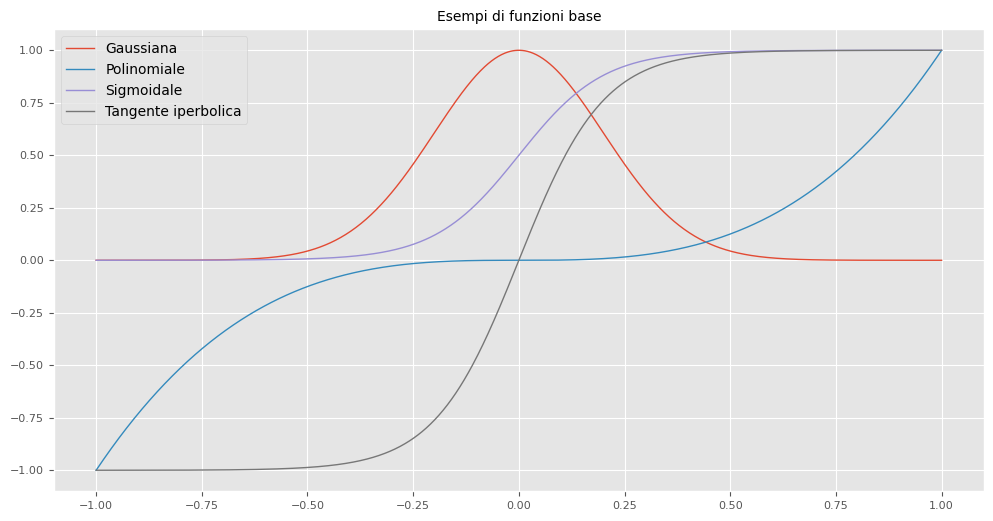

In [112]:
fig =plt.figure(figsize=(12,6))
x = np.linspace(-1,1,1000)
plt.plot(x, partial(gaussian_basis_function, **{'mu':0, 'sigma':0.2})(x), linewidth=1, label='Gaussiana')
plt.plot(x, partial(polynomial_basis_function, **{'power':3})(x), linewidth=1, label='Polinomiale')
plt.plot(x, partial(sigmoid_basis_function, **{'mu':0, 'sigma':.1})(x), linewidth=1, label='Sigmoidale')
plt.plot(x, partial(tanh_basis_function, **{'mu':0, 'sigma':.1})(x), linewidth=1, label='Tangente iperbolica')
plt.legend()
plt.title('Esempi di funzioni base')
plt.show()

### Dataset considerati

I dataset considerati negli esempi seguenti sono basati su $n$ osservazioni scalari $x_{i = 1,\ldots,n}$ raccolti in una matrice (vettore colonna) $\mathbf{X}$, di dimensione $n \times 1$. I valori target $\mathbf{t}$ sono generati da $\mathbf{X}$ per mezzo di due funzioni `f` e `g` che introducono anche del rumore casuale gaussiano con varianza predefinita e specificata dal parametro `noise_variance`. La funzione `f` sarà utilizzata per generare campioni rumorosi da una linea retta, mentre `g` genererà compioni casuali rumorosi per una sinusoide.

In [86]:
#valori parametri per la funzione f
f_w0 = -0.3
f_w1 =  0.5

def f(X, noise_variance):
    #Funzione lineare con rumore gaussiano additivo
    return f_w0+f_w1*X+noise(X.shape, noise_variance)

def g(X, noise_variance):
    #Funzione sinusoidale con rumore gaussiano additivo
    return 0.5+np.sin(2*np.pi*X)+noise(X.shape, noise_variance)

def noise(size, variance):
    return np.random.normal(scale=np.sqrt(variance), size=size)

In [6]:
# calcola griglia di punti per la visualizzazione della funzione f
x = np.linspace(-1, 1, 1000).reshape(-1, 1)
# calcola valori assunti da f nei punti
y1 = f(x, noise_variance=0)

# estrae un campione di n elementi nel dataset
n = 50
X = np.random.rand(n, 1)*2-1

# calcola i corrispondenti valori target applicando la funzione f e aggiungendo rumore con precision beta
beta = 25.0
t1 = f(X, noise_variance=1/beta)

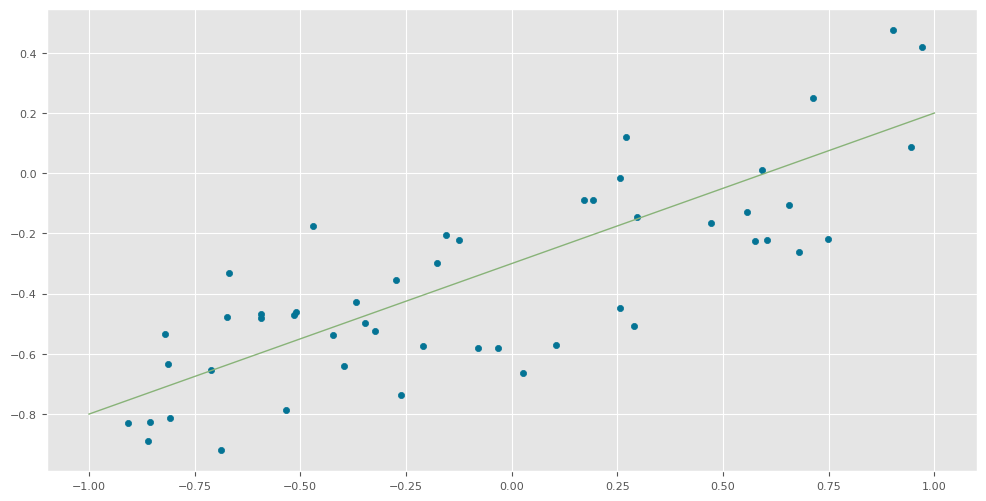

In [87]:
# plot della funzione f e del dataset
fig = plt.figure(figsize=(12,6))
plt.scatter(X, t1, s=20, color=colors[1])
plt.plot(x, y1, linewidth=1, color=colors[3])
plt.show()

In [ ]:
#calcola i valori associati ai punti per mezzo della funzione g
t2 = g(X, noise_variance=1/beta)
y2 = g(x, noise_variance=0)

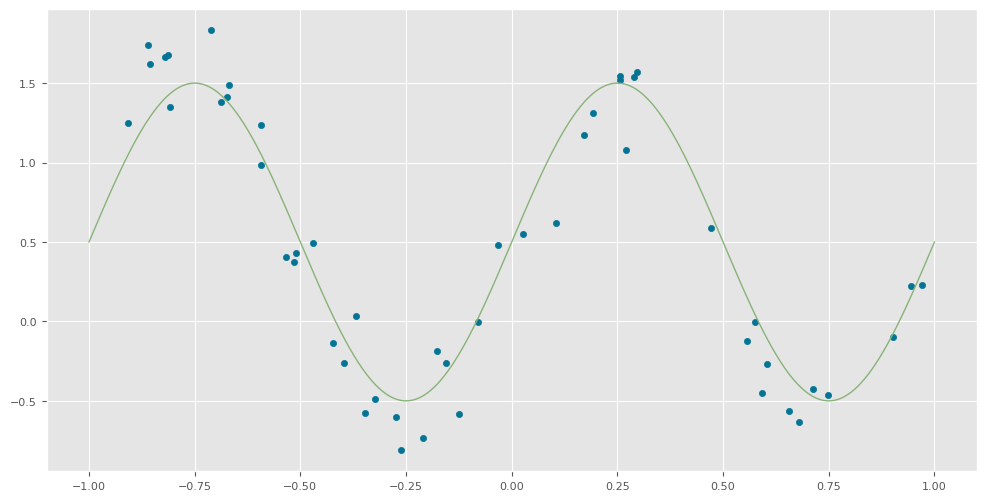

In [88]:
# plot della funzione g e del dataset
fig = plt.figure(figsize=(12,6))
plt.scatter(X, t2, s=20, color=colors[1])
plt.plot(x, y2, linewidth=1, color=colors[3])
plt.show()

### Funzioni base

Un modello lineare nell'input $x$ è sufficiente per una predizione effettuata nel primo caso, in cui la funzione `f' è una retta. In questo caso, non è necessario trasformare $x$ per mezzo di una funzione base, il che è equivalente a usare una funziona base identità. Per effettuare predizioni nel caso del dataset sinusoidale sarà conveniente trasformare l'input $x$ ad esempio per mezzo di una funzione base gaussiana o, come vedremo, con funziona base polinomiale. Queste funzioni base non lineari sono necessarie per modellare la relazione non lineare tra elementi $x$ e target corrispondente $t$. La _design matrix_ $\boldsymbol\Phi$ viene calcolata dalle osservazioni $\mathbf{X}$ per mezzo di una funzione base parametrica attraverso la funzione `expand`. Questa funzione inserisce in $\boldsymbol\Phi$ anche un vettore colonna costante $\mathbf{1}$ a rappresentare l'ipotesi $\phi_0(x) = 1$.

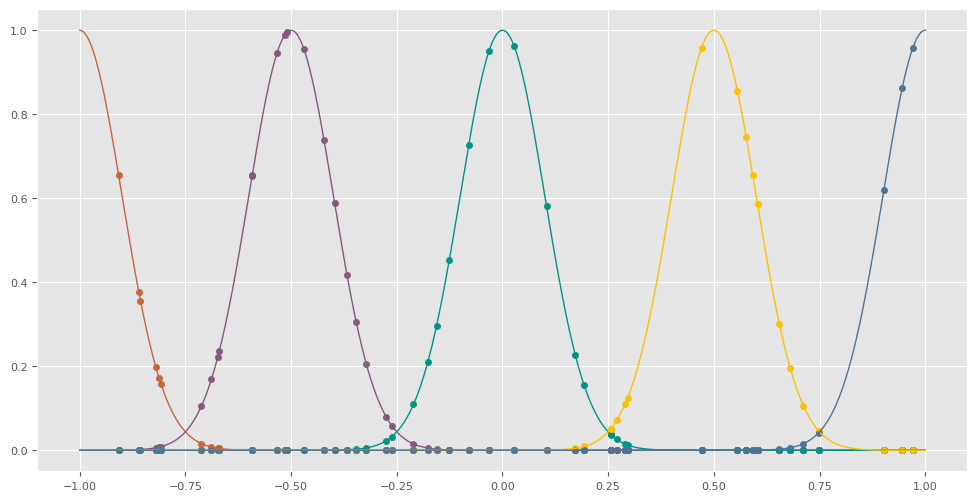

In [111]:
# funzioni base gaussiane 
# numero di funzioni base considerate
k = 5

# medie delle funzioni base, distribuite sull'intervallo considerato
mus = np.linspace(-1, 1, k)

fig = plt.figure(figsize=(12,6))
plt.scatter(X, np.zeros_like(X), s=20, color=colors[1])
for i, mu in enumerate(mus):  
    plt.plot(x, partial(gaussian_basis_function, **{'mu':mu, 'sigma':0.1})(x), linewidth=1, color=colors[4+i])
    plt.scatter(X, partial(gaussian_basis_function, **{'mu':mu, 'sigma':0.1})(X), s=20, color=colors[4+i])
plt.show()

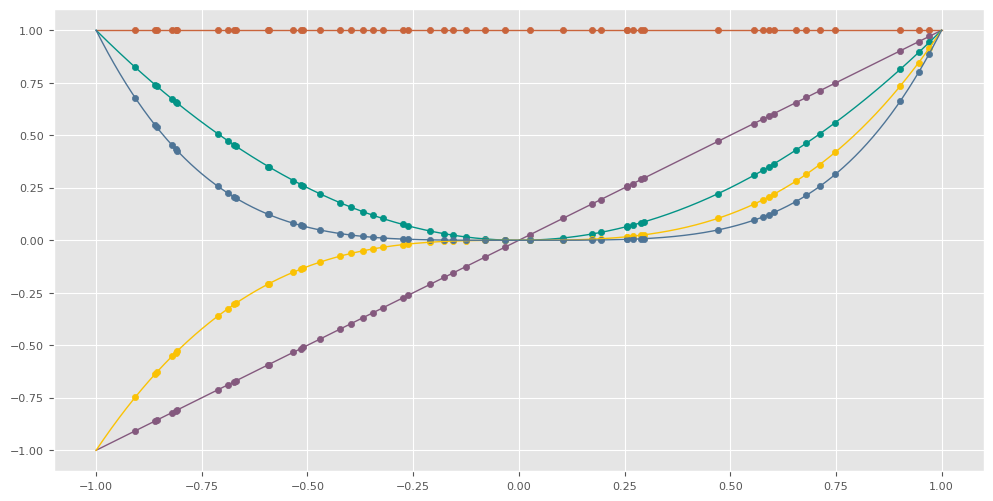

In [110]:
# funzioni base polinomiali 
k = 5

# grado delle funzioni base
powers = np.arange(k)

fig = plt.figure(figsize=(12,6))
for i, power in enumerate(powers):  
    plt.plot(x, partial(polynomial_basis_function, **{'power':power})(x), linewidth=1, color=colors[4+i])
    plt.scatter(X, partial(polynomial_basis_function, **{'power':power})(X), s=20, color=colors[4+i])
plt.show()

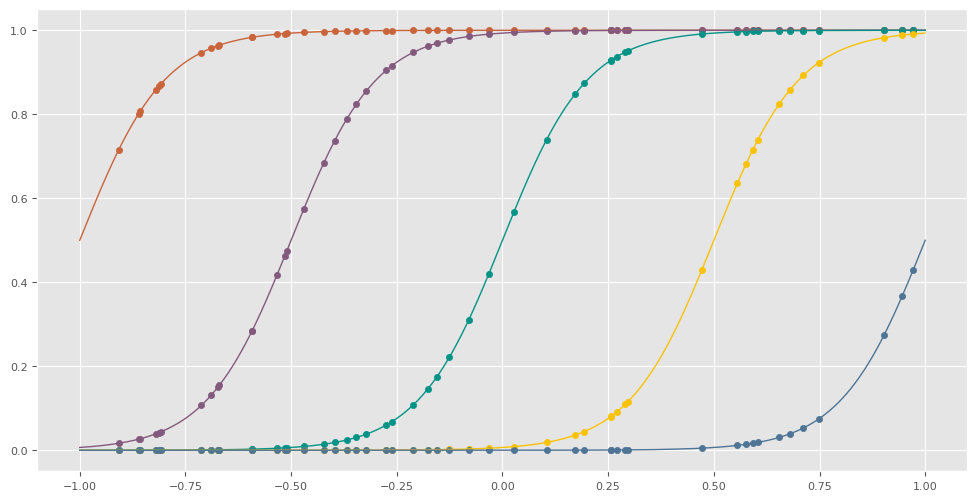

In [109]:
# funzioni base sigmoidali 
k = 5

# punti centrali delle funzioni base, distribuiti sull'intervallo considerato
mus = np.linspace(-1, 1, k)

fig = plt.figure(figsize=(12,6))
for i, mu in enumerate(mus):  
    plt.plot(x, partial(sigmoid_basis_function, **{'mu':mu, 'sigma':0.1})(x), linewidth=1, color=colors[4+i])
    plt.scatter(X, partial(sigmoid_basis_function, **{'mu':mu, 'sigma':0.1})(X), s=20, color=colors[4+i])
plt.show()

## Minimizzazione del rischio empirico

In questo approccio, viene definito un insieme $\mathcal{H}$ di possibili funzioni predicttive, selezionando quella che minimizza il rischio empirico

$$
\overline{\mathcal{R}}(h; \mathbf{X},\mathbf{t})=\frac{1}{n}\sum_{i=1}^nL(h(\mathbf{x}_i),t_i)
$$

cioè,

$$
\hat{h}=\underset{h\in\mathcal{H}}{\mathrm{argmin}}\;\overline{\mathcal{R}}(h;\mathbf{X},\mathbf{t})
$$

dove $L(x_1,x_2)$ è una funzione di costo (_loss_) predefinita.

Nel caso considerato qui, si assume che:

- l'insieme delle ipotesi $\mathcal{H}$ è un insieme di funzioni lineari parametriche $\sum_{j=0}^{m-1}{w_j \phi_j(\mathbf{x})}=\mathbf{\phi}(\mathbf{x})^T\mathbf{w}$
- la funzione di costo è il _residuo quadratico_ $(h(\mathbf{x})-t)^2$, il che implica che la minimizzazione del rischio empirico è definita come 
  
$$
\overline{\mathcal{R}}_\mathbf{\phi}(\mathbf{w}; \mathbf{\Phi},\mathbf{t})=\frac{1}{n}\sum_{i=1}^n\left(\sum_{j=0}^{m-1}{w_j \phi_j(\mathbf{x}_i)}-t_i\right)^2=\frac{1}{n}\sum_{i=1}^n\left(\mathbf{\phi}(\mathbf{x}_i)^T\mathbf{w}-t_i\right)^2=
{1 \over n} \lVert \mathbf{\Phi} \mathbf{w} - \mathbf{t}\rVert^2
$$

dove la _design matrix_ $\boldsymbol\Phi$ è definita come
$$
\boldsymbol\Phi = 
\begin{pmatrix}
\phi_0(\mathbf{x}_1) &  \phi_1(\mathbf{x}_1) & \cdots & \phi_{m-1}(\mathbf{x}_1) \\ 
\phi_0(\mathbf{x}_2) &  \phi_1(\mathbf{x}_2) & \cdots & \phi_{m-1}(\mathbf{x}_2) \\
\vdots & \vdots & \ddots & \vdots \\
\phi_0(\mathbf{x}_n) &  \phi_1(\mathbf{x}_n) & \cdots & \phi_{m-1}(\mathbf{x}_n)
\end{pmatrix}
$$

e la minimizzazione è eseguita nello spazio $\mathbb{R}^m$ dei parametri
$$
\hat{\mathbf{w}}=\underset{\mathbf{w}\in\mathbb{R}^m}{\mathrm{argmin}}\;\overline{\mathcal{R}}_\mathbf{\phi}(\mathbf{w};\mathbf{X},\mathbf{t})
$$

La funzione predittiva risultante è quindi $\hat{h}(\mathbf{x})=\boldsymbol\phi(\mathbf{x})^T\hat{\mathbf{w}}$.

Nelle ipotesi poste, il rischio empirico ha un solo minimo locale, che è anche globale, corrispondente al valore dei parametri
$$
\hat{\mathbf{w}}=(\boldsymbol\Phi^{T}\boldsymbol\Phi)^{-1}\boldsymbol\Phi^{T}\mathbf{t}
$$

In [101]:
# minimizzazione del rischio empirico
def erm(X, t, args):
    X_ = expand(X, **args)
    return np.dot(np.dot(np.linalg.inv(np.dot(X_.T, X_)), X_.T), t)

In [100]:
# funzione predittiva
def predict(X, w, args):
    y = np.dot(expand(x, **args), w)
    if np.isscalar(x):
        return y.item()
    else:
        return y

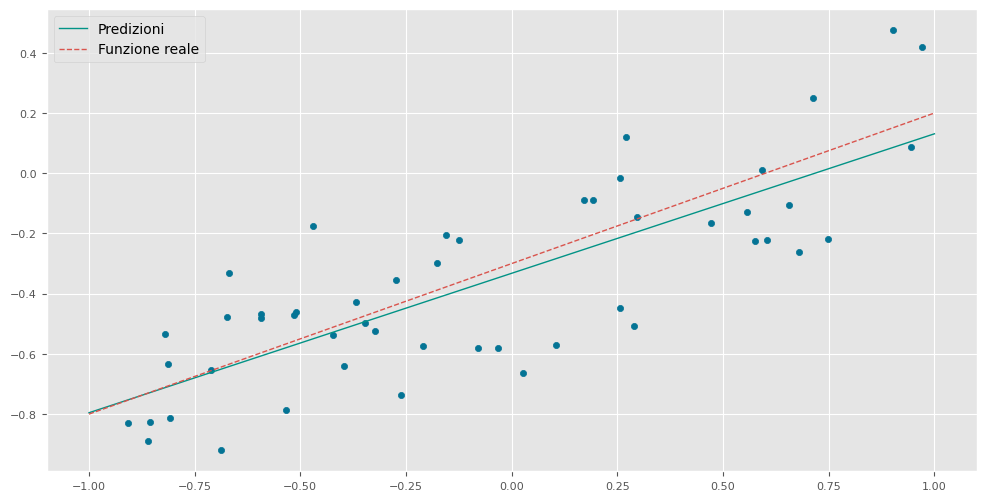

In [108]:
# caso funzione f lineare
args = {}

# calcola parametri che minimizzano il rischio empirico
w_star = erm(X, t1, args)

# visualizza funzione corretta f e valori predetti
fig = plt.figure(figsize=(12,6))
plt.scatter(X, t1, s=20, color=colors[1])
plt.plot(x, predict(x,w_star, args), linewidth=1, color=colors[6], label='Predizioni')
plt.plot(x, y1, linewidth=1, color=colors[2], linestyle='dashed', label='Funzione reale')
plt.legend()
plt.show()

In [104]:
# caso funzione g sinusoidale
# numero di funzioni base
k = 10

# medie delle funzioni base gaussiane
mus = np.linspace(-1, 1, k)


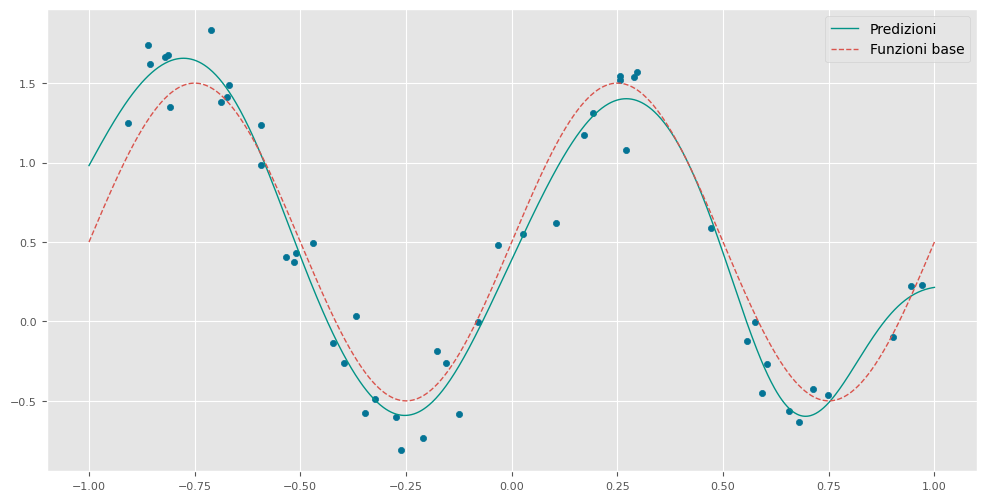

In [107]:
args = {'bf': sigmoid_basis_function, 'bf_args_list':[{'mu':mu} for mu in mus]}

# minimizza il rischio empirico dopo applicazione delle funzioni base
w_star = erm(X, t2, args)

fig = plt.figure(figsize=(12,6))
plt.scatter(X, t2, s=20, color=colors[1])
plt.plot(x, predict(x,w_star, args), linewidth=1, color=colors[6], label='Predizioni')
plt.plot(x, y2, linewidth=1, color=colors[2], linestyle='dashed', label='Funzioni base')
plt.legend()
plt.show()

## Metodi probabilistici

In questo approccio viene considerata una famiglia di modelli probabilistici da cui derivare la `distribuzione congiunta' $p(\mathbf{x}, t|\mathbf{w})$. A partire da questa distribuzione, viene derivata la distribuzione condizionata $p(t|\mathbf{x}, \mathbf{X}, \mathbf{t})$ del target dato l'elemento (e il dataset),  utilizzata per le predizioni.

Dato che $p(\mathbf{x}, t|\mathbf{w})=p(t|\mathbf{x},\mathbf{w})p(\mathbf{x}|\mathbf{w})$ e dato che, inoltre, $p(\mathbf{x}|\mathbf{w})$ è in generale assunta uniforme, e quindi indipendente da $\mathbf{w}$, è possibile considerare la sola distribuzione condizionata 
$p(t|\mathbf{x},\mathbf{w})$ e il modello probabilistico parametrico può essere definito rispetto a questa distribuzione.

Una prima idea generale, qui, consiste nel calcolare un valore $\hat{\mathbf{w}}_{ML}$ che massimizza, al variare di $\mathbf{w}$, la probabilità dei dati disponibili $\mathbf{X}, \mathbf{t}$. Questa probabilità, assumendo che gli elementi siano indipendenti e uniformemente distribuiti, e che il target associato a un elemento sia indipendente da tutti gli altri elementi e dai relativi target, risulta

$$
\hat{\mathbf{w}}_{ML} = \underset{\mathbf{w}\in\mathbb{R}^m}{\mathrm{argmax}}\; p(\mathbf{X}, \mathbf{t}|\mathbf{w})=  \underset{\mathbf{w}\in\mathbb{R}^m}{\mathrm{argmax}}\; \prod_{i=1}^np(\mathbf{x}_i, t_i|\mathbf{w})=\underset{\mathbf{w}\in\mathbb{R}^m}{\mathrm{argmax}}\; \prod_{i=1}^np(t_i|\mathbf{x}_i,\mathbf{w})p(\mathbf{x}_i|\mathbf{w}) = \underset{\mathbf{w}\in\mathbb{R}^m}{\mathrm{argmax}}\; \prod_{i=1}^np(t_i|\mathbf{x}_i,\mathbf{w})
$$

La distribuzione predittiva è allora $p(t|\mathbf{x}, \mathbf{X}, \mathbf{t})=p(t|\mathbf{x}, \hat{\mathbf{w}}_{ML})$.

Si noti che, in generale, 
$$
p(t|\mathbf{x}, \mathbf{X}, \mathbf{t}) = \int p(t, \mathbf{w}|\mathbf{x}, \mathbf{X}, \mathbf{t})d\mathbf{w}= \int p(t|\mathbf{x}, \mathbf{w}, \mathbf{X}, \mathbf{t})p(\mathbf{w}|\mathbf{x}, \mathbf{X}, \mathbf{t})d\mathbf{w}= \int p(t|\mathbf{x}, \mathbf{w})p(\mathbf{w}|\mathbf{X}, \mathbf{t})d\mathbf{w}
$$
As shown in the graphical model in figure, we assume that 
$t$ is independent from $\mathbf{X}$ and $\mathbf{t}$ if $\mathbf{w}$ and $\mathbf{x}$ are given, and $\mathbf{w}$ is independent from $\mathbf{x}$.

<img src="../assets/gm_lr.png" height="200">

Choosing only a specific value of $\mathbf{w}$, such as $\hat{\mathbf{w}}$ results into
$$
p(t|\mathbf{x}, \mathbf{X}, \mathbf{t}) = \int p(t|\mathbf{x}, \mathbf{w})p(\mathbf{w}|\mathbf{X}, \mathbf{t})d\mathbf{w} \approx \int p(t|\mathbf{x}, \hat{\mathbf{w}})p(\mathbf{w}|\mathbf{X}, \mathbf{t})d\mathbf{w}= p(t|\mathbf{x}, \hat{\mathbf{w}}) \int p(\mathbf{w}|\mathbf{X}, \mathbf{t})d\mathbf{w} = p(t|\mathbf{x}, \hat{\mathbf{w}})
$$

The probabilistic model considered here assumes that the target variable $t$ of an observation $\mathbf{x}$ is given by applying a deterministic function $h(\mathbf{x}, \mathbf{w})$ and adding to the result a random noise $\epsilon$. 

$$
t = h(\mathbf{x}, \mathbf{w}) + \epsilon \tag{2}
$$

We make the assumption that the noise is normally distributed i.e. it follows a Gaussian distribution with zero mean and given, but unknown, precision (= inverse variance) $\beta$. The corresponding probabilistic model i.e. the conditional distribution of $t$ given $\mathbf{x}$ can therefore be written as

$$
p(t \lvert \mathbf{x}, \mathbf{w}, \beta) = 
\mathcal{N}(t \lvert h(\mathbf{x}, \mathbf{w}), \beta^{-1}) =
\sqrt{\beta \over {2 \pi}} \exp\left(-{\beta \over 2} (t - h(\mathbf{x}, \mathbf{w}))^2 \right) \tag{3}
$$

The mean of this distribution is the `regression function` $h(\mathbf{x}, \mathbf{w})$. 

## Likelihood function

Assuming a set of basis function $\boldsymbol\phi(\mathbf{x})$ is applied, the joint conditional probability of targets $\mathbf{t}$ given $\mathbf{X}$ is

$$
p(\mathbf{t} \lvert \mathbf{X}, \mathbf{w}, \beta) = 
\prod_{i=1}^{n}{\mathcal{N}(t_i \lvert \mathbf{w}^T \boldsymbol\phi(\mathbf{x}_i), \beta^{-1})} \tag{4}
$$

This is a function of parameters $\mathbf{w}$ and $\beta$ and is called the *likelihood function*. The log of the likelihood function can be written as 

$$
\log p(\mathbf{t} \lvert \mathbf{X}, \mathbf{w}, \beta) = 
{n \over 2} \log \beta - 
{n \over 2} \log {2 \pi} - 
\beta E_D(\mathbf{w}) \tag{5}
$$

where $E_D(\mathbf{w})$ is the sum-of-squares error function coming from the exponent of the likelihood function.

$$
E_D(\mathbf{w}) = 
{1 \over 2} \sum_{i=1}^{n}(t_i - \mathbf{w}^T \boldsymbol\phi(\mathbf{x}_i))^2 = 
{1 \over 2} \lVert \mathbf{t} - \boldsymbol\Phi \mathbf{w} \rVert^2 \tag{6}
$$

## Maximum likelihood

Maximizing the log likelihood is clearly equivalent to minimizing the empirical risk defined above w.r.t. $\mathbf{w}$. Maximum likelihood estimation can lead to severe over-fitting if complex models (e.g. polynomial regression models of high order) are fit to datasets of limited size. A common approach to prevent over-fitting is to add a regularization term to the error function. As we will see shortly, this regularization term arises naturally when following a Bayesian approach (more precisely, when defining a prior distribution over parameters $\mathbf{w}$). 

Actually, an estimate of the uncertainty can also be derived by maximizing the likelihood with respect to $\beta$, which results into 

$$
\hat{\beta}^{-1}=\frac{1}{n}\sum_{i=1}^n\left(t_i-h(\mathbf{x}_i,\hat{\mathbf{w}})\right)^2= \frac{1}{n}\sum_{i=1}^n\left(t_i-\hat{\mathbf{w}}^T\mathbf{\phi}(\mathbf{x})\right)^2
$$

In [17]:
def mle(X, t, bf=None, bf_args_list=None):
    X_ = expand(X, bf, bf_args_list)
    return np.dot(np.dot(np.linalg.inv(np.dot(X_.T, X_)), X_.T), t)

In [18]:
def std_ml(X, t, w, args):
    y = np.dot(expand(X, **args), w)
    return np.sqrt(np.mean((t-y)**2))

In [19]:
args1 = {}

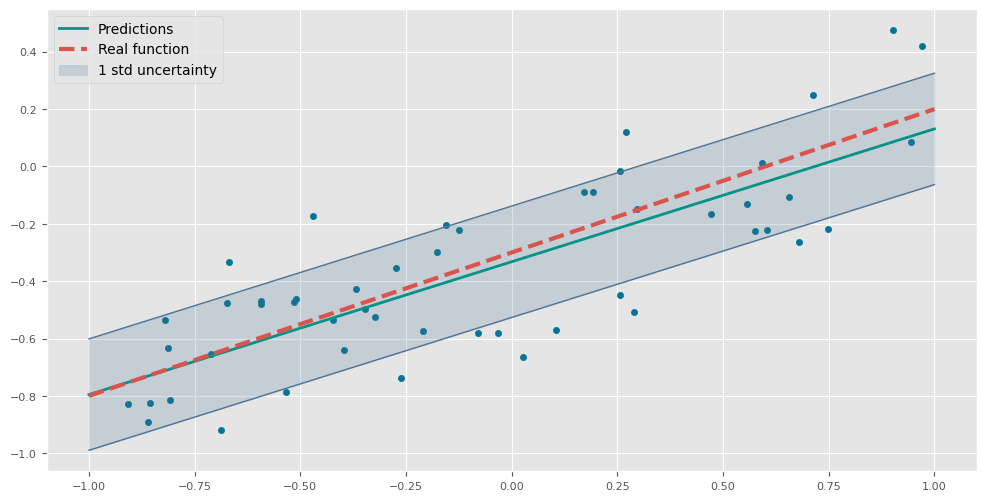

In [20]:
w_ML = erm(X, t1, args1)
std_ML = std_ml(X, t1, w_ML, args1)
fig = plt.figure(figsize=(12,6))
plt.scatter(X, t1, s=20, color=colors[1])
pred = predict(x,w_ML, args1)
plt.plot(x, pred, linewidth=2, color=colors[6], label='Predictions')
plt.plot(x, pred-std_ML, linewidth=1, color=colors[8])
plt.plot(x, pred+std_ML, linewidth=1, color=colors[8])
plt.plot(x, y1, linewidth=3, color=colors[2], linestyle='dashed', label='Real function')
plt.fill_between(x.ravel(), (pred-std_ML).ravel(), (pred+std_ML).ravel(), color=colors[8], alpha=.2, label='1 std uncertainty')
plt.legend()
plt.show()

In [21]:
k = 10
mus = np.linspace(-1, 1, k)
args2 = {'bf': gaussian_basis_function, 'bf_args_list':[{'mu':mu} for mu in mus]}

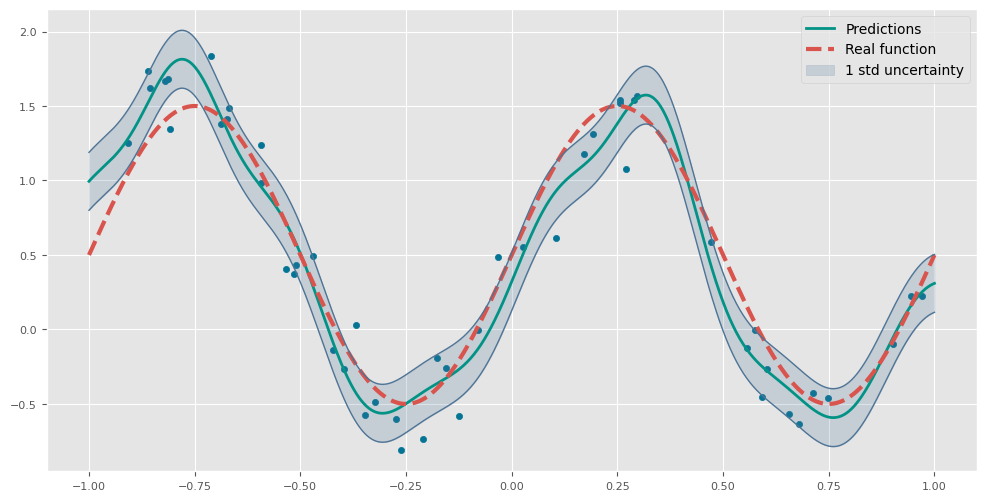

In [22]:
w_ML = erm(X, t2, args2)
fig = plt.figure(figsize=(12,6))
plt.scatter(X, t2, s=20, color=colors[1])
pred = predict(x,w_ML, args2)
plt.plot(x, pred, linewidth=2, color=colors[6], label='Predictions')
plt.plot(x, y2, linewidth=3, color=colors[2], linestyle='dashed', label='Real function')
plt.plot(x, pred-std_ML, linewidth=1, color=colors[8])
plt.plot(x, pred+std_ML, linewidth=1, color=colors[8])
plt.fill_between(x.T.squeeze(), (pred-std_ML).ravel(), (pred+std_ML).ravel(), color=colors[8], alpha=.2, label='1 std uncertainty')
plt.legend()
plt.show()

## Bayesian approach

### Prior and posterior distribution

For a Bayesian treatment of linear regression we need a prior probability distribution over model parameters $\mathbf{w}$. For reasons of simplicity, we will use here an isotropic Gaussian distribution over parameters $\mathbf{w}$ with zero mean:

$$
p(\mathbf{w} \lvert \alpha) = \mathcal{N}(\mathbf{w} \lvert \mathbf{0}, \alpha^{-1}\mathbf{I}) 
$$

An isotropic Gaussian distribution has a diagonal covariance matrix where all diagonal elements have the same variance $\alpha^{-1}$ ($\alpha$ is the precision of the prior). A zero mean favors small(er) values of parameters $w_j$ a priori. 

In [23]:
def plot_bivariate_gaussian(mean, cov, resolution = 100):
    grid_x = grid_y = np.linspace(-1, 1, resolution)
    grid_flat = np.dstack(np.meshgrid(grid_x, grid_y)).reshape(-1, 2)
    densities = stats.multivariate_normal.pdf(grid_flat, mean=mean.ravel(), cov=cov).reshape(resolution, resolution)
    plt.imshow(densities, origin='lower', extent=(-1, 1, -1, 1))
    plt.xticks([-1,-.5,0,.5,1])
    plt.yticks([-1,-.5,0,.5,1])
    plt.xlabel('$w_0$')
    plt.ylabel('$w_1$')

In [24]:
alpha = 10
cov = 1/alpha*np.eye(2, dtype=int)
mean = np.zeros(2)

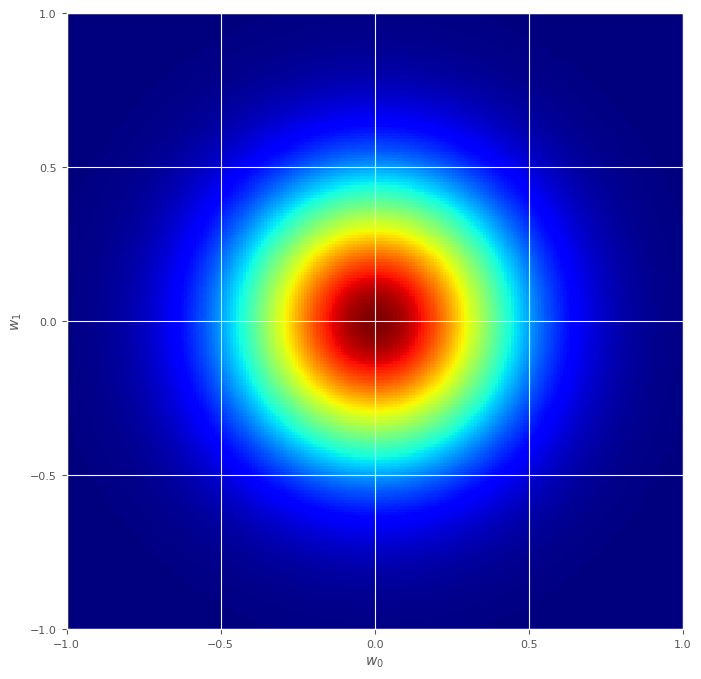

In [25]:
plt.figure(figsize=(8,8))
plot_bivariate_gaussian(mean, cov, 200)
plt.show()

The prior is *conjugate* to the likelihood $p(\mathbf{t} \lvert \mathbf{w}, \beta)$: that is, the posterior distribution has the same functional form as the prior i.e. it is also a Gaussian. In this special case, the posterior has an analytical solution with the following sufficient statistics 

$$
\mathbf{m}_n = \beta \mathbf{S}_n \Phi^T \mathbf{t}  \tag{9}
$$

$$
\mathbf{S}_n = \left(\alpha\mathbf{I} + \beta \Phi^T \Phi\right)^{-1}  \tag{10}
$$



$(9)$ is the mean vector of the posterior and $(10)$ the inverse covariance matrix (= precision matrix). Hence, the posterior distribution can be written as

$$
p(\mathbf{w} \lvert \mathbf{X}, \mathbf{t}, \alpha, \beta) = \mathcal{N}(\mathbf{w} \lvert \mathbf{m}_n, \mathbf{S}_n) \tag{11}
$$

For the moment, we assume that the values of $\alpha$ and $\beta$ are known. Since the posterior is proportional to the product of likelihood and prior, the log of the posterior distribution is proportional to the sum of the log likelihood and the log of the prior

$$
\log p(\mathbf{w} \lvert \mathbf{X}, \mathbf{t}, \alpha, \beta) = 
-\beta E_D(\mathbf{w}) - \alpha E_W(\mathbf{w}) + \mathrm{const.} \tag{12}
$$

where, as defined by $(6)$,

$$
E_D(\mathbf{w}) = 
{1 \over 2} \sum_{i=1}^{n}(t_i - \mathbf{w}^T \boldsymbol\phi(\mathbf{x}_i))^2 = 
{1 \over 2} \lVert \mathbf{t} - \boldsymbol\Phi \mathbf{w} \rVert^2
$$

and moreover

$$
E_W(\mathbf{w}) = {1 \over 2} \mathbf{w}^T \mathbf{w} =
{1 \over 2} \lVert \mathbf{w} \rVert^2\tag{13}
$$

Maximizing the log posterior w.r.t. $\mathbf{w}$ gives the *maximum-a-posteriori* (MAP) estimate of $\mathbf{w}$. Maximizing the log posterior is equivalent to minimizing the sum-of-squares error function $E_D$ plus a quadratic regularization term $E_W$. This particular form regularization is known as *L2 regularization* or *weight decay* as it limits the magnitude of weights $w_j$. The contribution of the regularization term is determined by the ratio $\alpha / \beta$.

### Posterior predictive distribution

For making a prediction $t$ at a new location $\mathbf{x}$ we use the posterior predictive distribution which is defined as

$$
p(t \lvert \mathbf{x}, \mathbf{X}, \mathbf{t}, \alpha, \beta) = 
\int{p(t \lvert \mathbf{x}, \mathbf{w}, \beta) p(\mathbf{w} \lvert \mathbf{X}, \mathbf{t}, \alpha, \beta) d\mathbf{w}} \tag{14}
$$

The posterior predictive distribution includes uncertainty about parameters $\mathbf{w}$ into predictions by weighting the conditional distribution $p(t \lvert \mathbf{x}, \mathbf{w}, \beta)$ with the posterior probability of weights $p(\mathbf{w} \lvert \mathbf{X}, \mathbf{t}, \alpha, \beta)$ over the entire weight parameter space. By using the predictive distribution we're not only getting the expected value of $t$ at a new location $\mathbf{x}$ but also the uncertainty for that prediction. In our special case, the posterior predictive distribution is a Gaussian distribution

$$
p(t \lvert \mathbf{x}, \mathbf{X}, \mathbf{t}, \alpha, \beta) = 
\mathcal{N}(t \lvert \mathbf{m}_n^T \boldsymbol\phi(\mathbf{x}), \sigma_n^2(\mathbf{x})) \tag{15}
$$

where mean $\mathbf{m}_n^T \boldsymbol\phi(\mathbf{x})$ is the regression function after $n$ observations and $\sigma_n^2(\mathbf{x})$ is the corresponding predictive variance

$$
\sigma_n^2(\mathbf{x}) = {1 \over \beta} + \boldsymbol\phi(\mathbf{x})^T \mathbf{S}_n \boldsymbol\phi(\mathbf{x}) \tag{16}
$$

The first term in $(16)$ represents the inherent noise in the data and the second term covers the uncertainty about parameters $\mathbf{w}$. So far, we have assumed that the values of $\alpha$ and $\beta$ are known. 


In [26]:
def posterior_ss(Phi, t, alpha, beta):
    """Computes mean and covariance matrix of the posterior distribution."""
    S_N_inv = alpha * np.eye(Phi.shape[1]) + beta * Phi.T.dot(Phi)
    S_N = np.linalg.inv(S_N_inv)
    m_N = beta * S_N.dot(Phi.T).dot(t)
    return m_N, S_N


def posterior_predictive_ss(phi, m_N, S_N, beta):
    """Computes mean and variances of the posterior predictive distribution."""
    y = phi.dot(m_N)
    y_var = 1 / beta + np.sum(phi.dot(S_N)*phi, axis=1)
    return y, y_var

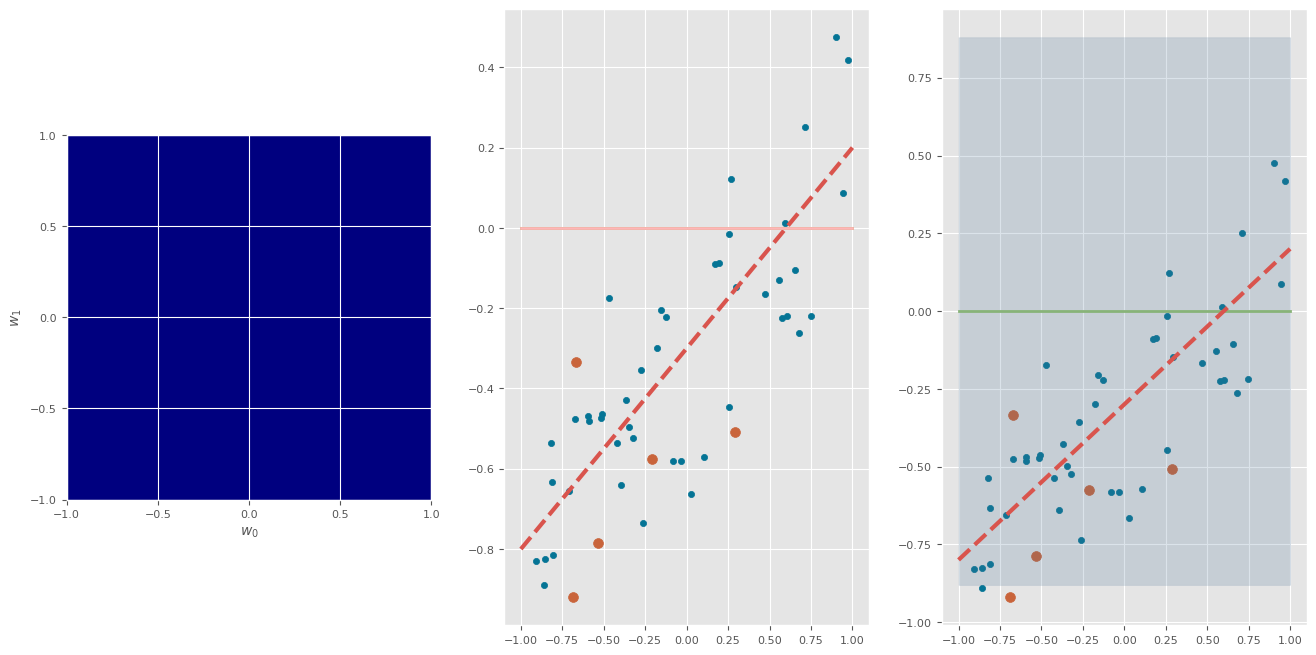

In [45]:
nexamples = 5
nsamples = 7
args1 = {}
X_ = expand(X[:nexamples], **args1)
mean_post, cov_post = posterior_ss(X_, t1[:nexamples], alpha, beta)
w_samples = np.random.multivariate_normal(mean_post.ravel(), cov_post, nsamples)

fig = plt.figure(figsize=(16,8))
plt.subplot(1,3,1)
plot_bivariate_gaussian(mean_post, cov_post, 200)
plt.subplot(1,3,2)
plt.scatter(X, t1, s=20, color=colors[1])
plt.scatter(X[:nexamples], t1[:nexamples], s=50, color=colors[4])
plt.plot(x, y1, linestyle='dashed', linewidth=3, color=colors[2])
for w in w_samples:
    plt.plot(x, np.dot(expand(x, **args1), w.reshape(-1,1)), linewidth=2)
plt.subplot(1,3,3)
y, y_var = posterior_predictive_ss(expand(x, **args1), mean_post, cov_post, beta)
plt.plot(x,y, color=colors[3], label='prediction')
plt.scatter(X, t1, s=20, color=colors[1])
plt.scatter(X[:nexamples], t1[:nexamples], s=50, color=colors[4])
plt.plot(x, y1, linestyle='dashed', linewidth=3, color=colors[2])
plt.fill_between(x.ravel(), y.ravel()-np.sqrt(y_var), y.ravel()+np.sqrt(y_var), color=colors[8], alpha=.2, label='1 std uncertainty')
plt.show()

In [28]:
k = 10
mus = np.linspace(-1, 1, k)
args2 = {'bf': sigmoid_basis_function, 'bf_args_list':[{'mu':mu} for mu in mus]}

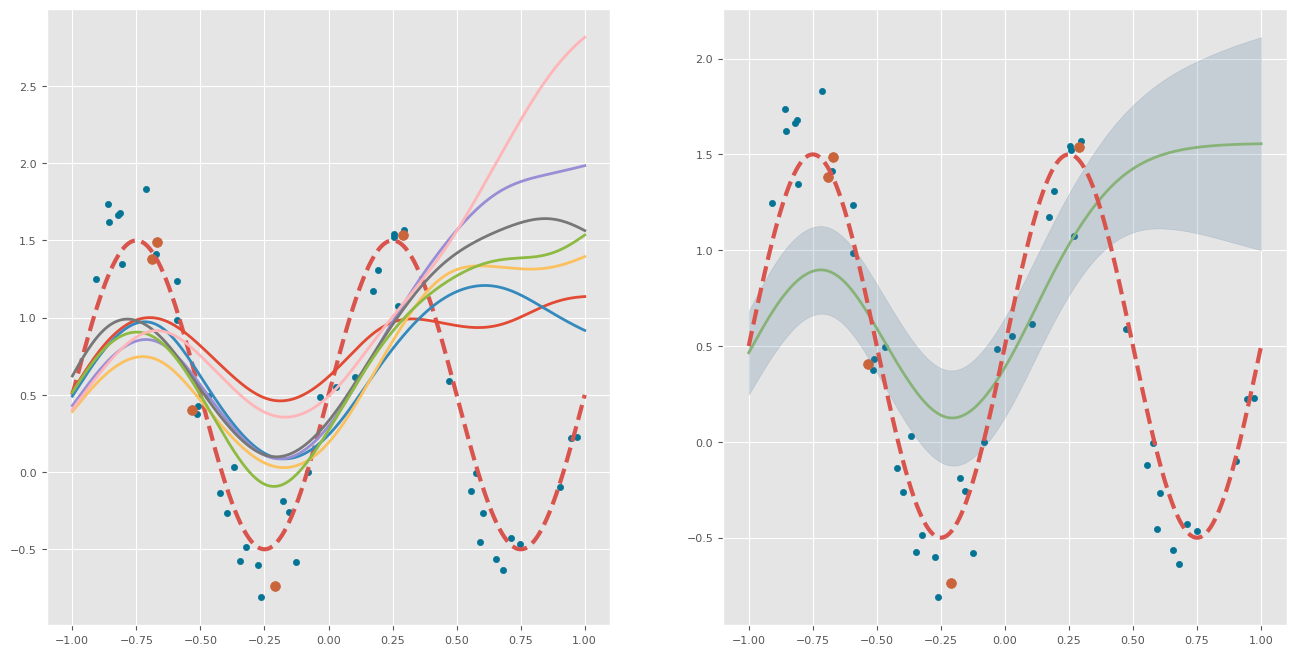

In [29]:
nexamples = 5
nsamples = 7
X_ = expand(X[:nexamples], **args2)
mean_post, cov_post = posterior_ss(X_, t2[:nexamples], alpha, beta)
w_samples = np.random.multivariate_normal(mean_post.ravel(), cov_post, nsamples)

fig = plt.figure(figsize=(16,8))
plt.subplot(1,2,1)
plt.scatter(X, t2, s=20, color=colors[1])
plt.scatter(X[:nexamples], t2[:nexamples], s=50, color=colors[4])
plt.plot(x, y2, linewidth=3, color=colors[2], linestyle='dashed', label='Real function')
for w in w_samples:
    plt.plot(x, np.dot(expand(x, **args2), w.reshape(-1,1)), linewidth=2)
plt.subplot(1,2,2)
y, y_var = posterior_predictive_ss(expand(x, **args2), mean_post, cov_post, beta)
plt.plot(x,y,color=colors[3],  label='prediction')

plt.plot(x, y2, linewidth=3, color=colors[2], linestyle='dashed', label='Real function')
plt.scatter(X, t2, s=20, color=colors[1])
plt.scatter(X[:nexamples], t2[:nexamples], s=50, color=colors[4])
plt.fill_between(x.ravel(), y.ravel()-np.sqrt(y_var), y.ravel()+np.sqrt(y_var), color=colors[8], alpha=.2, label='1 std uncertainty')
plt.show()

As the size of the dataset increases the posterior sample variance and the prediction uncertainty decreases. Also, regions with less observations have higher prediction uncertainty.

### Marginal likelihood and evidence

In a fully Bayesian treatment, however, we should define priors over $\alpha$ and $\beta$ and use the corresponding posteriors to additionally include uncertainties about $\alpha$ and $\beta$ into predictions. 

$$
p(t \lvert \mathbf{x}, \mathbf{X}, \mathbf{t}, \alpha, \beta) = 
\int{p(t \lvert \mathbf{x}, \mathbf{w}, \beta) p(\mathbf{w} \lvert \mathbf{X}, \mathbf{t}, \alpha, \beta) p(\alpha) p(\beta)d\mathbf{w}}\;d\alpha\;d\beta
$$

Unfortunately, complete integration over all three parameters $\mathbf{w}$, $\alpha$ and $\beta$ is analytically intractable and we have to use another approach. 

Estimates for $\alpha$ and $\beta$ can alternatively be obtained by considering the *marginal likelihood*, resulting by integrating out the parameters $\mathbf{w}$ from the likelihood

$$
p(\mathbf{X}, \mathbf{t} \lvert \alpha, \beta) =
\int{p(\mathbf{X}, \mathbf{t} \lvert \mathbf{w}, \beta) p(\mathbf{w} \lvert \alpha) d\mathbf{w}} 
$$

since $p(\alpha, \beta|\mathbf{X}, \mathbf{t})\propto p(\mathbf{X}, \mathbf{t} \lvert \alpha, \beta) p(\alpha, \beta)$, if we assume a uniform prior $p(\alpha,\beta)$ over the hyper-parameters then we may compare the probabilities of two pairs $\alpha_1, \beta_1$, given the training set $\mathbf{X}, \mathbf{t}$ by comparing the corresponding marginal likelihoods

$$
\frac{p(\alpha_1, \beta_1|\mathbf{X}, \mathbf{t})}{p(\alpha_2, \beta_2|\mathbf{X}, \mathbf{t})}=\frac{p(\mathbf{X}, \mathbf{t}|\alpha_1, \beta_1)}{p(\mathbf{X}, \mathbf{t}|\alpha_2, \beta_2)}
$$
this is called *Bayes factor*.

Since moreover $p(\mathbf{X}, \mathbf{t} \lvert \alpha, \beta)=p(\mathbf{t} \lvert \mathbf{X}, \alpha, \beta)p(\mathbf{t} \lvert \mathbf{X}, \alpha, \beta)$, if we make the usual hypothesis that $\mathbf{X}$ is independent from the model and its parameters (and hyper-parameters) it results 

$$
p(\mathbf{X}, \mathbf{t} \lvert \alpha, \beta)\propto p(\mathbf{t} \lvert \mathbf{X}, \alpha, \beta)
$$ 

where the second term is the *evidence* 

$$
p(\mathbf{t} \lvert \mathbf{X}, \alpha, \beta) =
\int{p(\mathbf{t} \lvert \mathbf{X}, \mathbf{w}, \beta) p(\mathbf{w} \lvert \alpha) d\mathbf{w}} 
$$

which is related to likelihood, prior, and posterior by Bayes' theorem

$$
p(\mathbf{w} \lvert \mathbf{X}, \mathbf{t}, \alpha, \beta) = 
{p(\mathbf{t} \lvert \mathbf{X}, \mathbf{w}, \beta) p(\mathbf{w} \lvert \alpha) \over p(\mathbf{t} \lvert \mathbf{X}, \alpha, \beta)}  
$$

Under these conditions, we may compare the probabilities of two pairs $\alpha_1, \beta_1$, given the training set $\mathbf{X}, \mathbf{t}$ by comparing the corresponding evidences

$$
\frac{p(\alpha_1, \beta_1|\mathbf{X}, \mathbf{t})}{p(\alpha_2, \beta_2|\mathbf{X}, \mathbf{t})}=\frac{p(\mathbf{t}|\mathbf{X}, \alpha_1, \beta_1)}{p(\mathbf{t}|\mathbf{X}, \alpha_2, \beta_2)}
$$

Integration over model parameters makes models of different complexity directly comparable, for example by comparing their evidences on training data alone without needing a validation set. 


In the framework of gaussian models for prior and likelihood considered here, the log of the evidence is given by

$$
\log p(\mathbf{t} \lvert \mathbf{X}, \alpha, \beta) = \frac{m}{2}\log\alpha + \frac{n}{2}\log\beta -
E(\mathbf{m}_n)-\frac{1}{2}\log\lvert\mathbf{S}_n^{-1}\rvert - \frac{n}{2}\log\frac{2}{\pi} \tag{18}
$$

where

$$
E(\mathbf{m}_n) = \frac{\beta}{2} \lVert \mathbf{t} - \boldsymbol\Phi \mathbf{m}_n \rVert^2 +
\frac{\alpha}{2} \mathbf{m}_n^T \mathbf{m}_n \tag{19}
$$


In [30]:
def log_marginal_likelihood(Phi, t, alpha, beta):
    """Computes the log of the marginal likelihood."""
    N, M = Phi.shape
    m_N, S_N = posterior_ss(Phi, t, alpha, beta)
    S_N_inv = np.linalg.inv(S_N)
    E_D = beta * np.sum((t - Phi.dot(m_N)) ** 2)
    E_W = alpha * np.sum(m_N ** 2)
    score = M*np.log(alpha) + N*np.log(beta) - E_D - E_W - np.log(np.linalg.det(S_N_inv)) - N*np.log(2*np.pi)

    return 0.5 * score

In [51]:
S_N.shape

(4, 4)

#### Maximization

Since $p(\alpha, \beta|\mathbf{X}, \mathbf{t})\propto p(\mathbf{X}, \mathbf{t} \lvert \alpha, \beta) p(\alpha, \beta)$
maximizing the marginal likelihood corresponds to maximizing the probability of the hyper-parameters given the training set.

The approach of maximizing the marginal likelihood or, equivalently, the evidence w.r.t. $\alpha$ and $\beta$ is known as *empirical Bayes*. It can be shown that this is a good approximation for a fully Bayesian treatment if the posterior for $\alpha$ and $\beta$ is sharply peaked around the most probable value and the prior is relatively flat which is often a reasonable assumption. 

Integrating over model parameters or using a good approximation for it allows us to estimate values for $\alpha$ and $\beta$, and hence the regularization strength $\alpha / \beta$, from training data alone i.e. without using a validation set.

The sets of gaussian basis function models are compared on the basis of the log marginal likelihood computed with a dataset of nexamples observations. We still assume that the values of $\alpha$ and $\beta$ are known and will see in the next section how they can be inferred by maximizing the log marginal likelihood. When plotting the posterior predictive distribution of the polynomial models we can see that a model of degree 5 has already sufficient complexity to explain the data reasonably well.

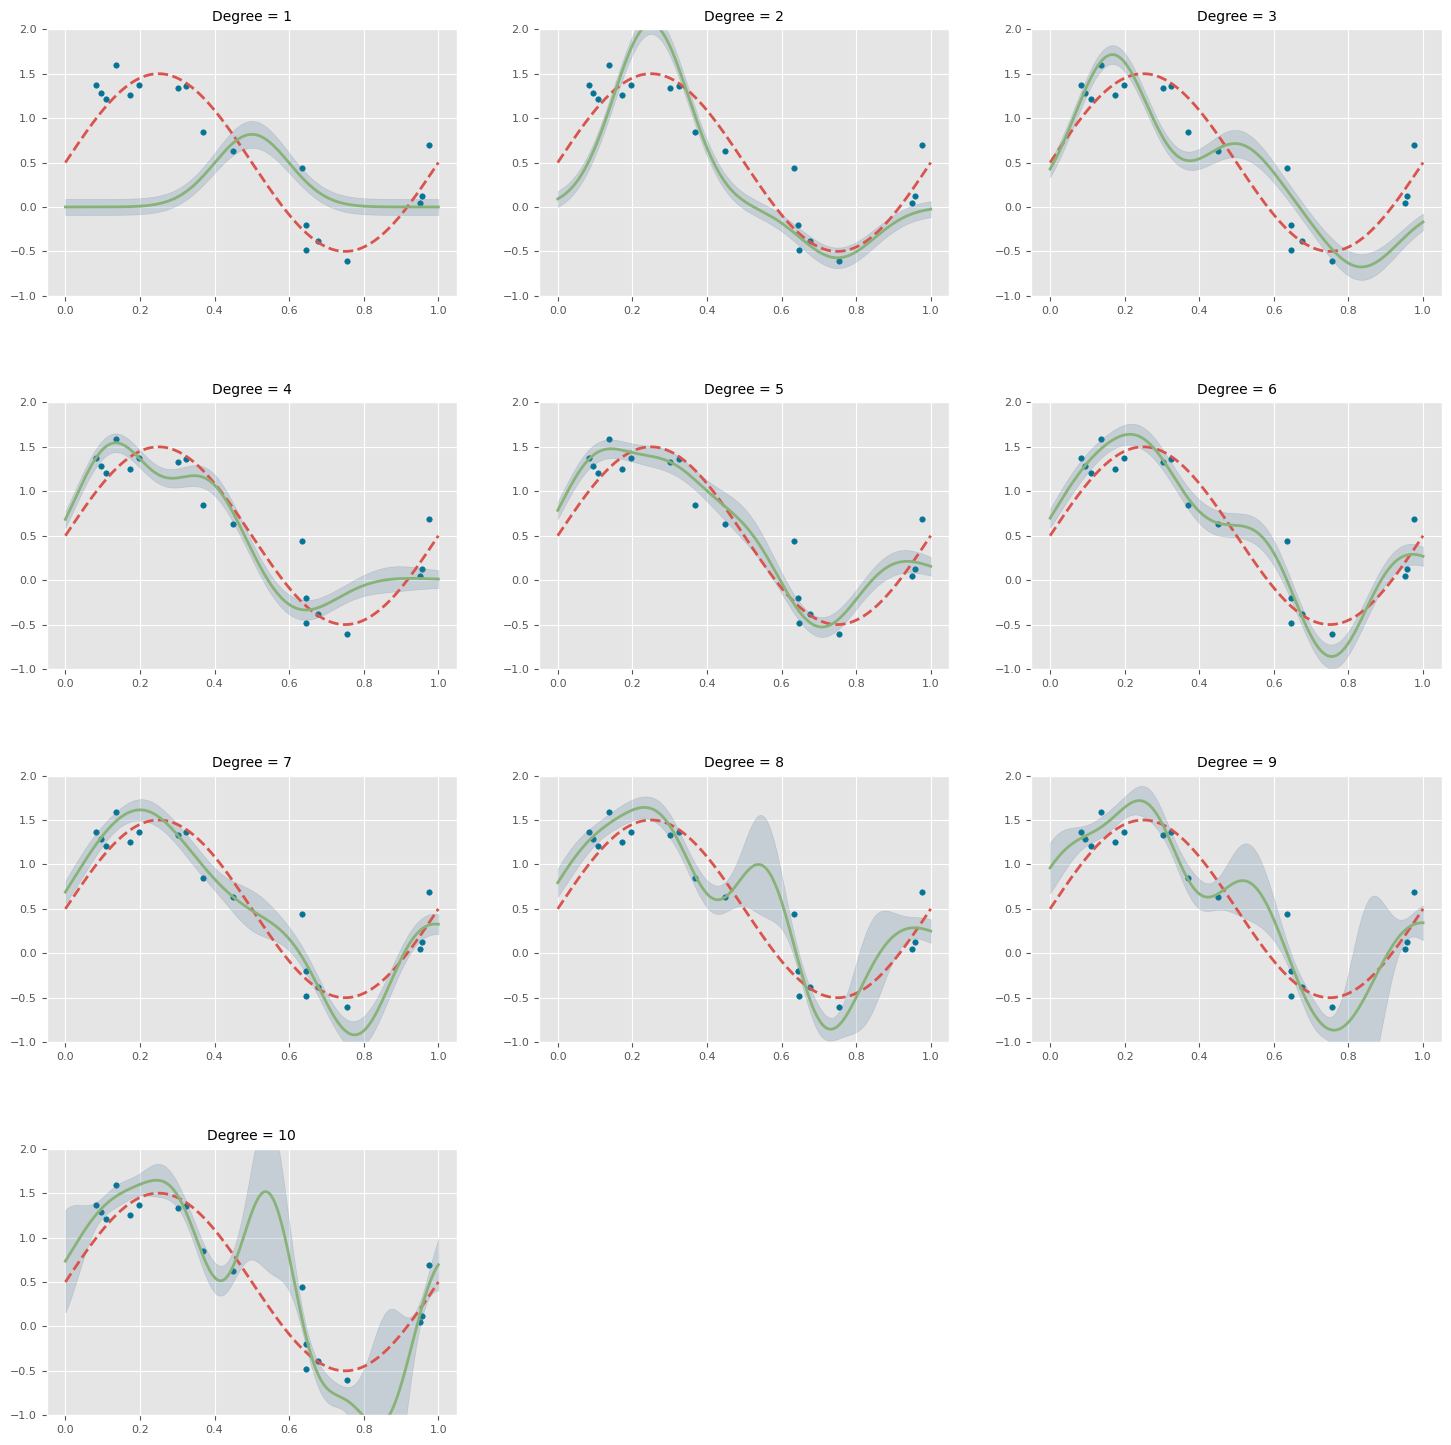

In [54]:
beta = 1/(0.3 ** 2)
alpha = 0.005

nexamples = 20

x0 = np.linspace(0, 1, 1000).reshape(-1, 1)
y0 = g(x0, noise_variance=0).T

X_s = np.random.rand(50, 1)
X0 = X_s[:nexamples]
t0 = g(X0, noise_variance=1/beta)

degree = 9
degrees = range(degree + 1)

m = 10
rows = int(m/3)+1

plt.figure(figsize=(18, 18))
plt.subplots_adjust(hspace=0.4)
for d in range(1, m+1):
    mus = np.linspace(x0[0], x0[-1], d+1)
    args = {'bf': gaussian_basis_function, 'bf_args_list':[{'mu':mus[k]+.5*(mus[k+1]-mus[k])} for k in range(len(mus)-1)]}
    X_ = expand(X0, **args)
    m_N, S_N = posterior_ss(X_, t0, alpha, beta)
    x_ = expand(x0, **args)
    y, y_var = posterior_predictive_ss(x_, m_N, S_N, beta)
    plt.subplot(rows, 3, d)
    plt.scatter(X0,t0, s=15, color=colors[1])
    plt.plot(x0,y0.ravel(), color=colors[2], linestyle='dashed')
    plt.plot(x0, y, color=colors[3])
    plt.fill_between(x0.ravel(),y.ravel()-y_var.ravel(),y.ravel()+y_var.ravel(), color=colors[8], alpha=.2)
    plt.title(f'Degree = {d}')
    plt.ylim(-1.0, 2.0)


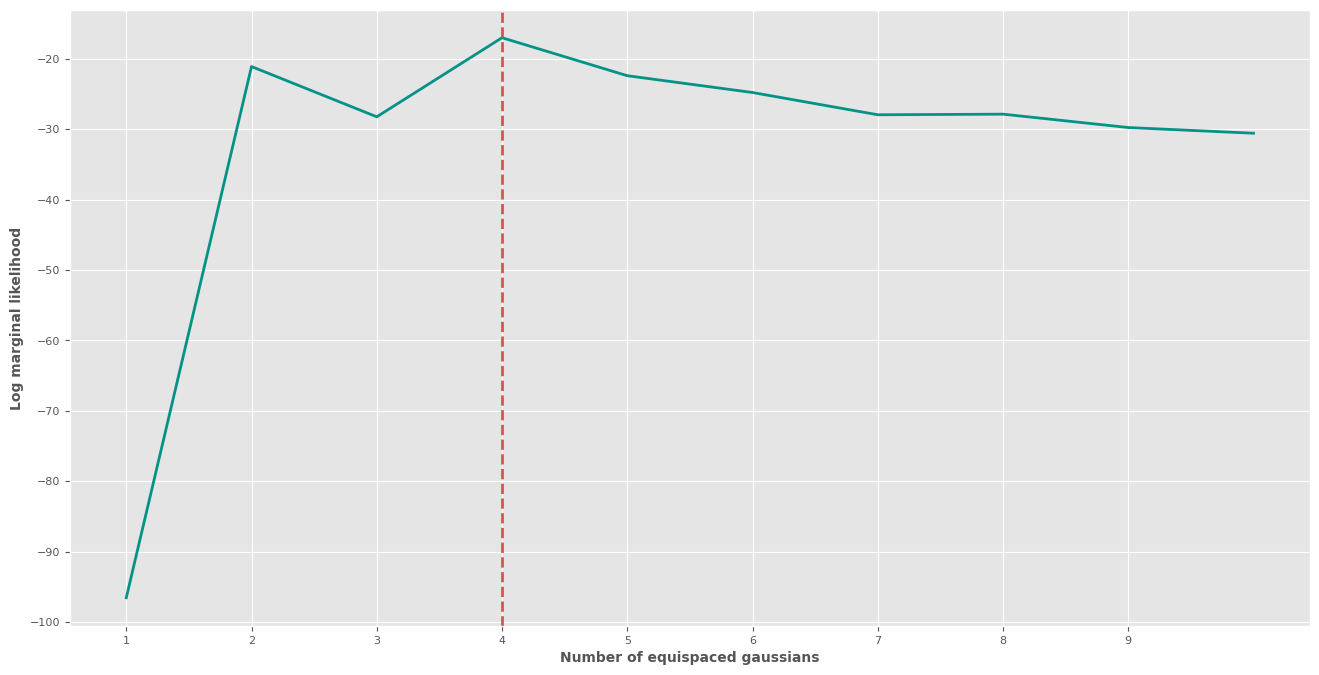

In [32]:
mlls = []

for d in range(1, m+1):
    mus = np.linspace(x0[0], x0[-1], d+1)
    args = {'bf': gaussian_basis_function, 'bf_args_list':[{'mu':mus[k]+.5*(mus[k+1]-mus[k])} for k in range(len(mus)-1)]}
    X_ = expand(X0, **args)
    mll = log_marginal_likelihood(X_, t0, alpha=alpha, beta=beta)
    mlls.append(mll)

degree_max = np.argmax(mlls)+1
plt.plot(range(1,m+1), mlls, color=colors[6])
plt.axvline(x=degree_max, linestyle='dashed', color=colors[2], lw=2)
plt.xticks(range(1, m))
plt.xlabel('Number of equispaced gaussians')
plt.ylabel('Log marginal likelihood');

In the case considered here, maximization of the log evidence (and of the log marginal likelihood) w.r.t. $\alpha$ and $\beta$ gives the following implicit solutions

$$
\alpha = \frac{\gamma}{\mathbf{m}_n^T \mathbf{m}_n} \tag{21}
$$

and 

$$
\frac{1}{\beta} = \frac{1}{n-\gamma} \sum_{i=1}^{n}(t_i - \mathbf{m}_n^T \boldsymbol\phi(\mathbf{x}_i))^2 \tag{22}
$$

where 

$$
\gamma = \sum_{i=0}^{m-1} \frac{\lambda_i}{\alpha+\lambda_i} \tag{23}
$$


and $\lambda_i$ are the *eigenvalues* of $\beta \boldsymbol\Phi^T \boldsymbol\Phi$. The solutions are implicit because both $\alpha$ and $\beta$ depend on $\gamma$ and $\gamma$ depends on both $\alpha$ and $\beta$. Solutions for $\alpha$ and $\beta$ can therefore be obtained by starting with initial values for these parameters and then iterating over the above equations until convergence.

In [33]:
def fit(Phi, t, alpha_0=1e-5, beta_0=1e-5, max_iter=200, rtol=1e-5, verbose=False):
    """
    Jointly infers the posterior sufficient statistics and optimal values 
    for alpha and beta by maximizing the log marginal likelihood.
    
    Args:
        Phi: Design matrix (N x M).
        t: Target value array (N x 1).
        alpha_0: Initial value for alpha.
        beta_0: Initial value for beta.
        max_iter: Maximum number of iterations.
        rtol: Convergence criterion.
        
    Returns:
        alpha, beta, posterior mean, posterior covariance.
    """
    N, M = Phi.shape
    eigenvalues_0 = np.linalg.eigvalsh(Phi.T.dot(Phi))
    beta = beta_0
    alpha = alpha_0
    for i in range(max_iter):
        beta_prev = beta
        alpha_prev = alpha
        eigenvalues = eigenvalues_0*beta
        m_N, S_N = posterior_ss(Phi, t, alpha, beta)
        gamma = np.sum(eigenvalues/(eigenvalues + alpha))
        alpha = gamma/np.sum(m_N**2)
        beta_inv = 1/(N-gamma)*np.sum((t-Phi.dot(m_N))**2)
        beta =1/beta_inv
        if np.isclose(alpha_prev, alpha, rtol=rtol) and np.isclose(beta_prev, beta, rtol=rtol):
            if verbose:
                print(f'Convergence after {i + 1} iterations.')
            return alpha, beta, m_N, S_N
    if verbose:
        print(f'Stopped after {max_iter} iterations.')
    return alpha, beta, m_N, S_N

In [34]:
N = 30

degree = 4

Xc = np.linspace(0, 1, N).reshape(-1, 1)
tc = g(Xc, noise_variance=0.3 ** 2)

args = {'bf': polynomial_basis_function, 'bf_args_list':[{'power':k} for k in range(1, degree + 1)]}
Phi = expand(Xc, **args)

alpha, beta, m_N, S_N = fit(Phi, tc, rtol=1e-5, verbose=True)
print('alpha* = {}'.format(alpha))
print('beta* = {}'.format(beta))

Stopped after 200 iterations.
alpha* = 2.0480186952166966e+17
beta* = 1.2910617400849849


Alternatively, we can also use *BayesianRidge* from scikit-learn for Bayesian regression. The `fit` and `predict` methods of this estimator are on the same abstraction level as our `fit` and `posterior_predictive` functions. The implementation of `BayesianRidge` is very similar to our implementation except that it uses *Gamma* priors over parameters $\alpha$ and $\beta$. The default hyper-parameter values of the Gamma priors assign high probability density to low values for $\alpha$ and $\beta$. In our implementation, we simply start optimization from low $\alpha$ and $\beta$ values. Note that `BayesianRidge` uses different parameter names (`lambda` instead of `alpha` and `alpha` instead of `beta`.

In [42]:
from sklearn.linear_model import BayesianRidge

br = BayesianRidge(fit_intercept=False, tol=1e-5, verbose=True)
br.fit(Phi, tc.ravel())
print('alpha* = {}'.format(br.lambda_))
print('beta* = {}'.format(br.alpha_))

Convergence after  39  iterations
alpha* = 0.0020496911133718013
beta* = 10.06708790513388


When comparing the results from our implementation with those from `BayesianRidge` we see that they are almost identical. In the following, inferred values for $\alpha$, $\beta$ and $\mathbf{m}_N$ are compared as well as predictions and their uncertainties. Results prefixed with `np` are those from our implementation, results prefixed with `br` are those obtained with `BayesianRidge`.

In [75]:
X_test = np.random.rand(10)

Phi_test = expand(X_test, **args)

In [78]:
Phi_test.shape

(10, 2)

In [79]:
y_np_mean, y_np_var = posterior_predictive_ss(X_test, m_N, S_N, beta)

print('Prediction mean: {}'.format(y_np_mean.ravel()))
print('Prediction std: {}'.format(np.sqrt(y_np_var)))

AxisError: axis 1 is out of bounds for array of dimension 1

Observe now that the expectation of the predictive distribution 
$$
\mathbf{m}_n^T\mathbf{\phi}(\mathbf{x})=(\beta\mathbf{S}_n\mathbf{\Phi}^{T}\mathbf{t})^T\mathbf{\phi}(\mathbf{x})
$$
can be written also as
$$
\mathbf{\phi}(\mathbf{x})^T\mathbf{m}_n=\beta\mathbf{\phi}(\mathbf{x})^{T}\mathbf{S}_n\mathbf{\Phi}^{T}\mathbf{t}=\sum_{i=1}^{n}\beta\mathbf{\phi}(\mathbf{x})^{T}\mathbf{S}_n\mathbf{\phi}(\mathbf{x}_{i})t_{i}
$$

If we assume that the prediction $y(\mathbf{x})$ for $\mathbf{x}$ corresponds to this expectation, then it can be seen as a linear combination $\sum_{i=1}^nw_it_i$ of the target values $t_i$ of the items in the training set, with weights $w_i=\beta\mathbf{\phi}(\mathbf{x})^{T}\mathbf{S}_N\mathbf{\phi}(\mathbf{x}_{i})$ dependent from the item values $\mathbf{x}_i$ (and from $\mathbf{x}$).

The weight function 
$$
\kappa(\mathbf{x},\mathbf{x}')=\beta\mathbf{\phi}(\mathbf{x})^{T}\mathbf{S}_n\mathbf{\phi}(\mathbf{x}')
$$
is said *equivalent kernel*

In [61]:
def equiv_kernel(x1, x2, X, t, alpha, beta, args):
    phi_1 = expand(x1, **args)
    phi_2 = expand(x2, **args)
    Phi = expand(X, **args)
    _, S = posterior_ss(Phi, t, alpha, beta)
    return beta*(phi_1.dot(S)).dot(phi_2.T)

In [62]:
def predict_equiv_kernel(X_test, X, t, alpha, beta, args):
    return np.sum(np.multiply(t, equiv_kernel(X_test, X, X, t, alpha, beta, args).T), axis=0)

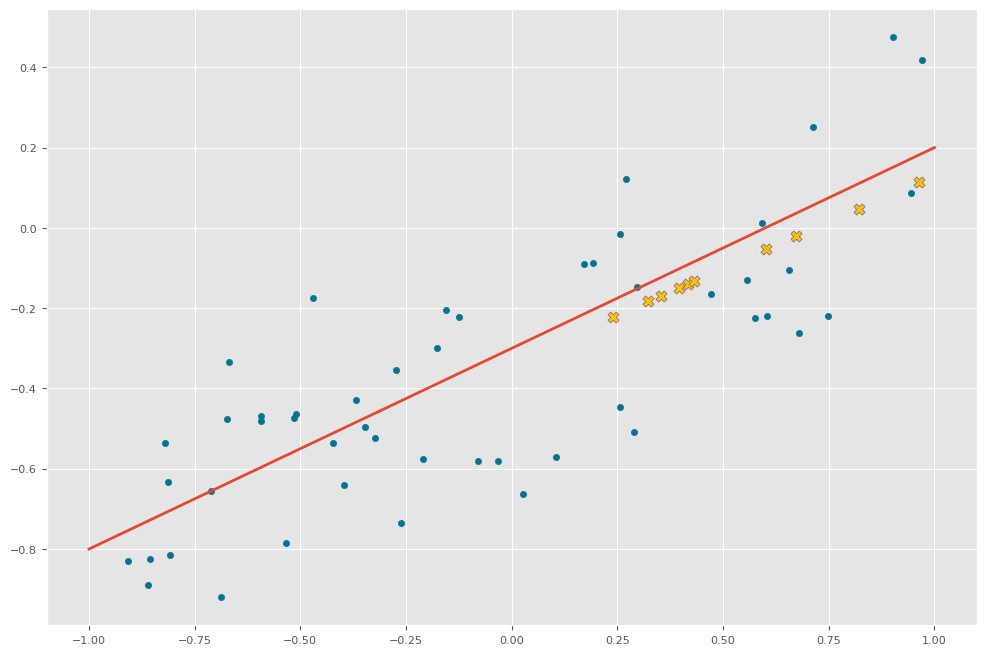

In [63]:
args = {}
plt.figure(figsize=(12,8))
plt.scatter(X, t1, s=20, color=colors[1])
plt.plot(x, y1, linewidth=2)
plt.scatter(X_test, predict_equiv_kernel(X_test, X, t1, alpha, beta, args), color=colors[7], edgecolor=colors[5], marker='X')
plt.show()

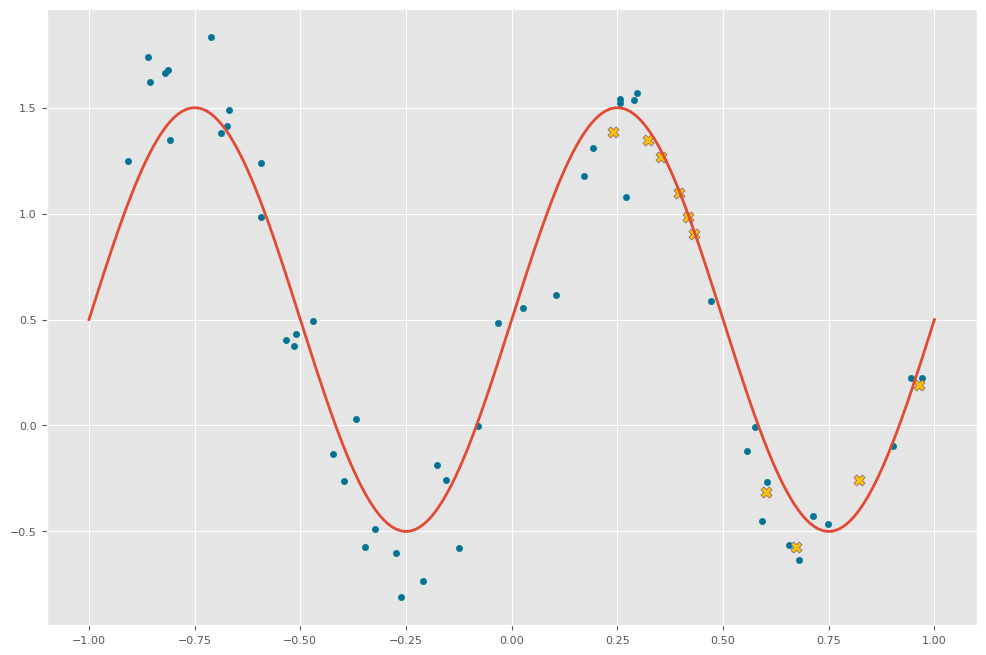

In [64]:
args = {}
plt.figure(figsize=(12,8))
plt.scatter(X, t2, s=20, color=colors[1])
plt.plot(x, y2, linewidth=2)
plt.scatter(X_test, predict_equiv_kernel(X_test, X, t2, alpha, beta, args2), color=colors[7], edgecolor=colors[5], marker='X')
plt.show()

In the images below the value of the equivalent kernel is reported in color (reddish color - higher value) for all pairs in the domain $(-1,1)\times(-1,1)$ for different sets of base functions. It is possible to see that pairs with similar values (that is, points along the diagonal) tend to result into higher equivalent kernel values. As a consequence, when predicting $y(\mathbf{x})$ the target values of points in the training set at smaller distance from $\mathbf{x}$ receive higher weights: This corresponds to the application of a locality principle: nearby examples are more relevant for predictions.

In [65]:
n_values = 200
xx = np.linspace(-1, 1, n_values)
yy = np.linspace(-1, 1, n_values)
XX,YY = np.meshgrid(xx, yy)
func=np.vectorize(lambda x,y:equiv_kernel(x,y,X,t1,alpha,beta,args))
Z=func(XX,YY)

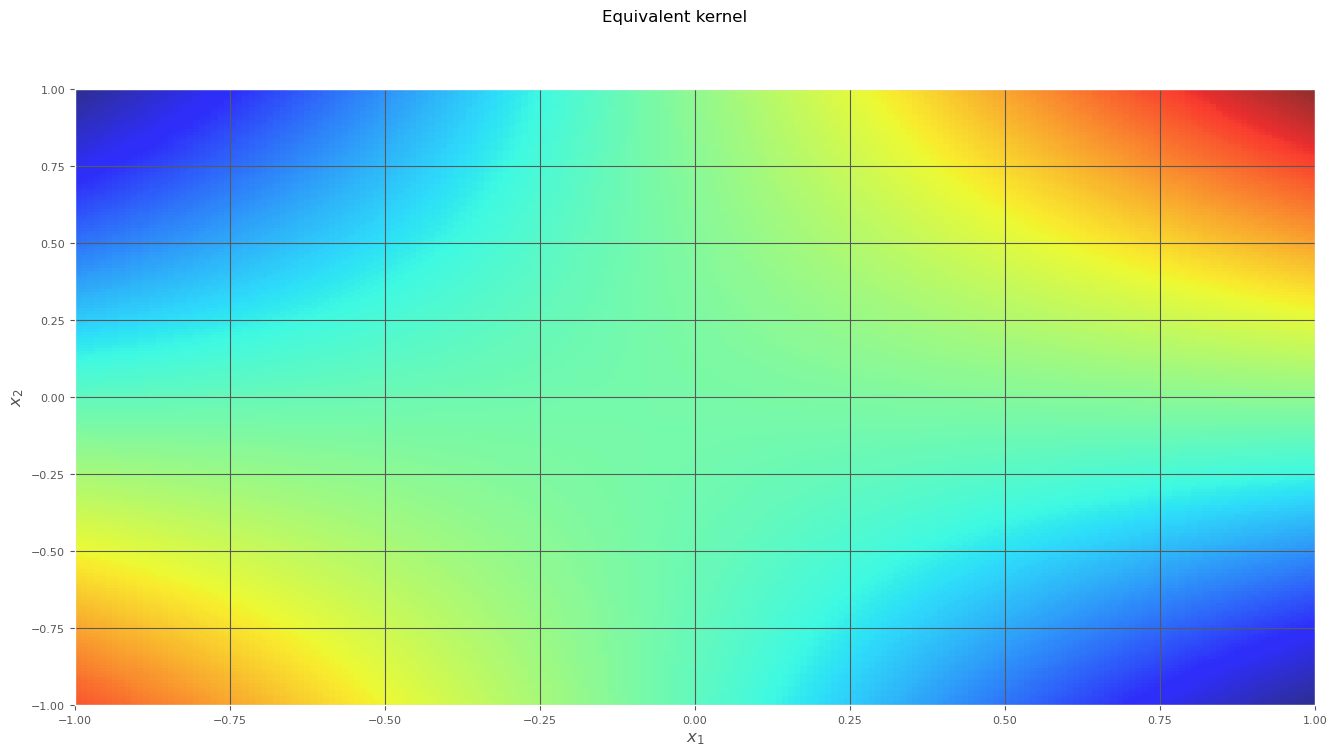

In [67]:
fig = plt.figure(figsize=(16,8))
ax=fig.gca()
imshow_handle = ax.imshow(Z, origin='lower', extent=(xx.min(),xx.max(), yy.min(), yy.max()), aspect='auto', alpha=.8)
ax.set_xlabel('$x_1$', fontsize=12)
ax.set_ylabel('$x_2$', fontsize=12)
plt.xlim(-1,1)
plt.ylim(-1,1)
ax.xaxis.set_tick_params(labelsize=8)
ax.yaxis.set_tick_params(labelsize=8)
ax.grid(which='both', color='0.35')
plt.suptitle(u'Equivalent kernel')
plt.show()

In [68]:
n_values = 200
xx = np.linspace(-1, 1, n_values)
yy = np.linspace(-1, 1, n_values)
XX,YY = np.meshgrid(xx, yy)
func = np.vectorize(lambda x,y:equiv_kernel(x,y,X,t2,alpha,beta,args2))
Z = func(XX,YY)

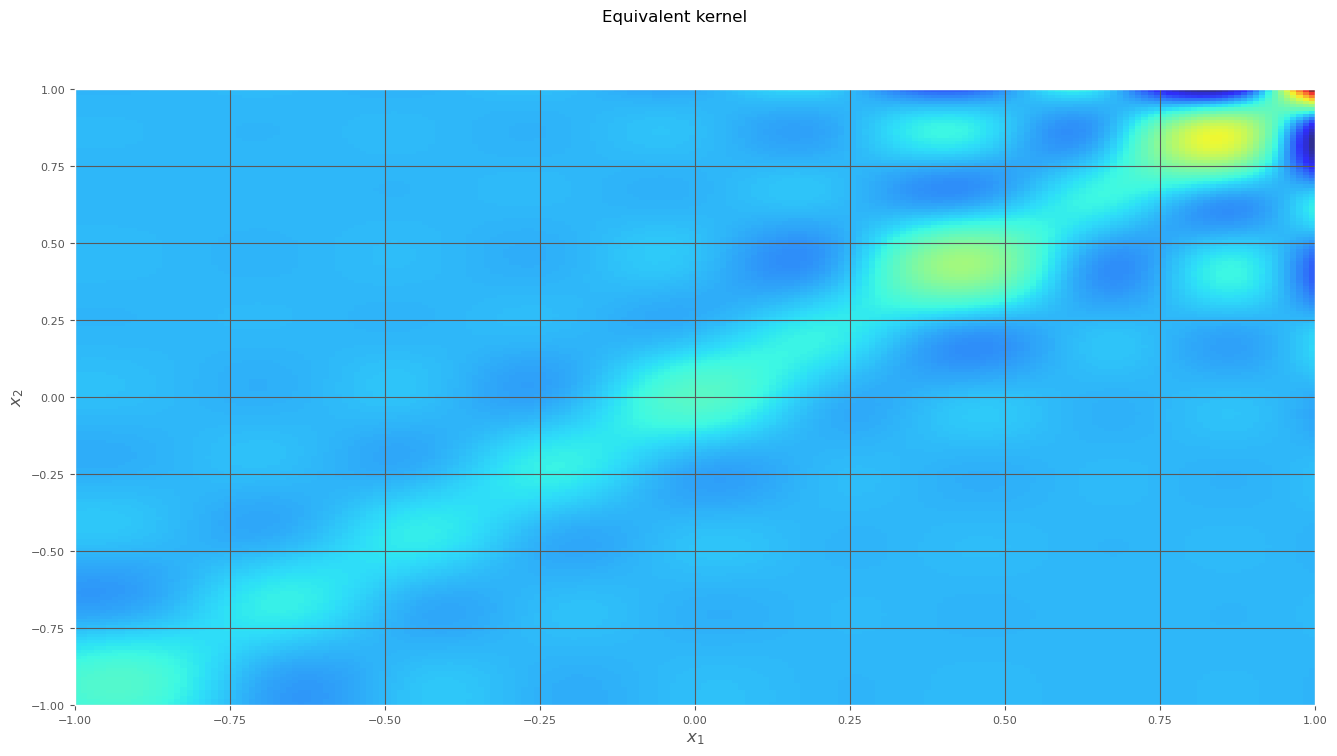

In [69]:
fig = plt.figure(figsize=(16,8))
ax=fig.gca()
imshow_handle = ax.imshow(Z, origin='lower', extent=(xx.min(),xx.max(), yy.min(), yy.max()), aspect='auto', alpha=.8)
ax.set_xlabel('$x_1$', fontsize=12)
ax.set_ylabel('$x_2$', fontsize=12)
plt.xlim(-1,1)
plt.ylim(-1,1)
ax.xaxis.set_tick_params(labelsize=8)
ax.yaxis.set_tick_params(labelsize=8)
ax.grid(which='both', color='0.35')
plt.suptitle(u'Equivalent kernel')
plt.show()